In [1]:
ENV["LINES"] = 9 # truncate IJulia display

9

# CMB maps

In [2]:
using CMBLensing, LinearAlgebra, PyPlot

In [3]:
f = LambertMap([1. 2; 3 4])

4-element 2×2-pixel 1.0′-resolution LambertMap{Array{Float64, 2}}:
 1.0
 3.0
 2.0
 4.0

In [4]:
f.arr

2×2 Matrix{Float64}:
 1.0  2.0
 3.0  4.0

In [5]:
f.proj

ProjLambert{Float64, Vector{Float64}, Matrix{Float64}}(2, 2, 1.0, (0.0, 90.0, 0.0), Array, 0.0002908882086657216, 8.461594994075237e-8, 10800.0, 10800.0, 10800.0, [0.0, -10800.0], [0.0, -10800.0], [0.0 10800.0; 10800.0 15273.506473629426], [0.0 -2.4492935982947064e-16; -1.2246467991473532e-16 1.0], [1.0 1.0; -1.0 -1.8369701987210297e-16])

## Abstract vector spaces

Although `f` represents a 2-dimensional map, it turns out to be extremely useful conceptually to consider `f` as an "abstract vector". So much so it hooks into Julia's type hierarchy for `AbstractVector`:

In [6]:
f isa AbstractVector

true

Abstract vectors spaces are defined by elements ("vectors") which can be multiplied by scalars and added to other vectors:
$$
\alpha \, f + g
$$

In [7]:
g = FlatMap([5. 6; 7 8]);

In [8]:
2 * f + g

4-element 2×2-pixel 1.0′-resolution LambertMap{Array{Float64, 2}}:
  7.0
 13.0
 10.0
 16.0

## Abstract vector vs. representation of a vector

Abstract vectors say nothing about how they are _represented_. We can represent the same abstract element of the vector space as the pixel values, or e.g. the 2D FFT of the pixel values:

In [9]:
g = Fourier(g)

4-element 2×2-pixel 1.0′-resolution LambertFourier{Array{ComplexF64, 2}}:
 26.0 + 0.0im
 -4.0 + 0.0im
 -2.0 + 0.0im
  0.0 + 0.0im

Scalar multiplication and addition still means the same thing regardless the representation the fields happen to be in:

In [10]:
2 * f + g

4-element 2×2-pixel 1.0′-resolution LambertMap{Array{Float64, 2}}:
  7.0
 13.0
 10.0
 16.0

(CMBLensing arbitrarily chooses to represent the result above as map)

## Broadcasting implementation

All fields in CMBLensing are just aliases of a common `BaseField` type (eg `LambertMap == BaseField{Map,ProjLambert}`:

```julia
struct BaseField{B, M<:Proj, T, A<:AbstractArray{T}} <: Field{B, T}
    arr :: A
    metadata :: M
end
```

Custom broadcasting rules are defined so that broadcasting across fields and scalars 1) preserves the field wrapper 2) forwards the broadcast _exactly_ to the underlying arrays 3) is inferred. E.g. this:

```julia
f .+ f
```
is roughtly equivalent to this:
```julia
BaseField(f.arr .+ f.arr, f.proj)
```

## Inner products

In [11]:
f

4-element 2×2-pixel 1.0′-resolution LambertMap{Array{Float64, 2}}:
 1.0
 3.0
 2.0
 4.0

In [12]:
f' * f

30.0

In [13]:
f' * Fourier(f)

30.0

## Diagonal operators

The maps we work with have ~millions of pixels, there's no operators (represented by matrices) which can be densely stored. So we build operators out of ones which are diagonal _when represented in a certain basis_. 

In [14]:
Diagonal(f)

4×4 Diagonal{Float64, LambertMap{Array{Float64, 2}}}:
 1.0   ⋅    ⋅    ⋅ 
  ⋅   3.0   ⋅    ⋅ 
  ⋅    ⋅   2.0   ⋅ 
  ⋅    ⋅    ⋅   4.0

In [15]:
Diagonal(f) * g

4-element 2×2-pixel 1.0′-resolution LambertMap{Array{Float64, 2}}:
  5.0
 21.0
 12.0
 32.0

## Real CMB maps

In [16]:
dataset = load_sim(Nside=128, pol=:I, θpix=1, T=Float64).ds
Cf = dataset.Cf()
Cϕ = dataset.Cϕ()

8320×8320 Diagonal{Float64, LambertFourier{Array{Float64, 2}}}:
 0.0   ⋅           ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅            ⋅ 
  ⋅   5.46398e-9   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅            ⋅ 
 ⋮                               ⋮    ⋱                         
  ⋅    ⋅           ⋅    ⋅    ⋅    ⋅       ⋅    ⋅   6.34679e-20   ⋅ 
  ⋅    ⋅           ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅           5.63467e-20

In [17]:
f = sqrt(Cf) * FlatMap(randn(128,128))
ϕ = sqrt(Cϕ) * FlatMap(randn(128,128))

8320-element 128×128-pixel 1.0′-resolution LambertFourier{Array{ComplexF64, 2}}:
                  -0.0 + 0.0im
 -0.004277073054850783 + 0.0023735253052976843im
                       ⋮
 -7.106454829839204e-9 + 2.4885609226291022e-8im
  2.002195439752523e-8 - 4.8771984512677686e-8im

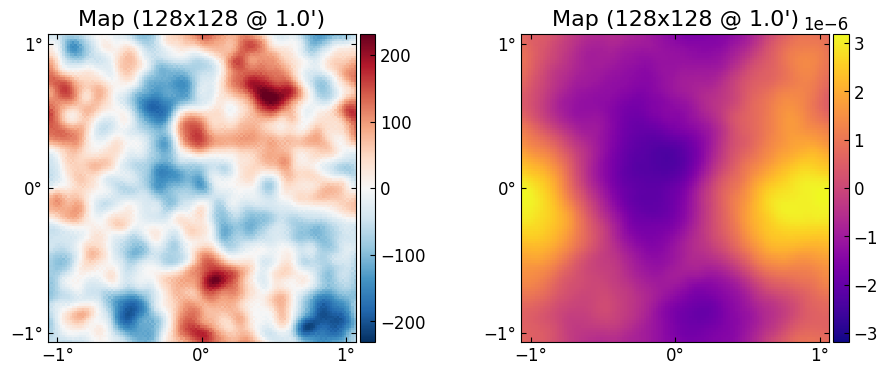

In [18]:
plot([f ϕ], cmap=["RdBu_r" "plasma"])

In [19]:
f' * pinv(Cf) * f

16284.909946921933

In [20]:
128^2

16384

In [21]:
logdet(Cf)

20819.514261236873

# Posteriors

We want to define the model in one place, and be able to generate simulations as well as compute the posterior probability. This is what Probabilistic Programming Languages (PPLs) are for, popular ones in Julia are Turing.jl, Gen.jl, and Tilde.jl. Unfortunately none quite satisfied everything we needed so we wrote our own, but its only 86 LOC.

In [22]:
using CMBLensing: @fwdmodel
using Distributions, Random

In [23]:
@fwdmodel function toy(;σ, x)
    σ ~ LogNormal(0, 3)
    x ~ Normal(0, σ)
end

toy (generic function with 2 methods)

In [24]:
simulate(Xoshiro(1), toy)

(σ = 0.8091674358795355, x = 0.43005368208832817)

In [25]:
logpdf(toy, σ=1, x=2)

-4.936489355077455

In [26]:
Cn = Diagonal(FlatMap(100 * ones(128,128)));

In [27]:
@fwdmodel function lensing_problem(;f, ϕ, Aϕ=1, d)
    f ~ MvNormal(0, Cf)
    ϕ ~ MvNormal(0, Aϕ * Cϕ)
    f̃ ← LenseFlow(ϕ) * f
    d ~ MvNormal(f̃, Cn)
end

lensing_problem (generic function with 2 methods)

In [28]:
sim = simulate(Xoshiro(1), lensing_problem);

In [29]:
logpdf(lensing_problem; sim.f, sim.ϕ, sim.d)

267862.70174525044

In [30]:
animate([sim.f, sim.f̃], fps=1)

HTML{String}("<video width=\"560\" height=\"400\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAp/xtZGF0AAACrgYF//+q\n3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MCByMzAxMSBjZGU5YTkzIC0gSC4yNjQvTVBF\nRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u\nb3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs\neXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk\nX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk\nZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy\nIGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50\nZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi\nX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w\nPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xIHNjZW5lY3V0PTQwIGludHJhX3Jl\nZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu\nNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAABu\n+2WIhAAW//730z/Msuv3ObXjqPeiniZfQ3UlAZuWxO06gAAAAwAAAwALRrqHni/9QD/4Uox8QA2q\nepWeFDF9U2IMq+Plv4LDFC+6CUK0FyjvGDp/U6NZ0peMAQunwo35MYkc6M+ES3MC2shvHoX78BAG\n/HNbS+PIXI0q9/nCM+tLn4nEqbLdAcrpwb83YyCdnaw3hqsqH77H3Ud3tG0dSKkQlJ5cfoL29Sz8\nDWybimWC89KoWg3fOjYyvi3kOT8YBypKrWYpTZeUEuMo5I3N9XBWBU2iDPQ9TZMXMilDcCEQ0dz2\nCcZtD/flIZBuYAUWV7B+dyd3b46tliBX1HOE9q12duUVgnr6OalweH3bd9+X6C2xneuEFNHA6Ii7\nd38QdEYvTy+0Ku6A5NaeWieDRBjOMpVBjuyME9o92ea9u6J2JeuH7uOPpyyo9F0bAkcXBj/QZkR+\ny+cLWv5GdOhpAmbLC0fvN2tUX6D1mOkXAdaC5yEzMl5ulCZpB7SK8hy32hxKzfTlLKI7Gv7Q4z29\nyK+v1LuUCo33wIovmt8XVvzPOWqFhwE5k5AOk9OJUNeQ7HSypMhzVpLhcbArqxavQ8ValJEzyRBk\nDk4XVL6T2X2L/Uy0AW7joVFlz64mN/M+x+qTDQ4M7hcS4wIyowsW96xHFUCRj0arwGEowLOWyhdA\nYiTc/YYJ/JcTx5UfW2nqn9E5vRSrQ1ZwkQ2+ud3m+KEPwTlSk5hf9V9dUIqgB44eKDFcw79hipde\nWKxlDEiSz5ytlqIR+RHy2IvqcWjR/rzO8PTzzzAg0DXb1aUHfKqi9OrgXU7N19GdK1UvnyMnn04S\nmM4ZbHwwoWee9y0ikVP46GeyRihJtNb2NJ/SRwLGFcrgRbi3kkh0hJB0AUt3iNy50/QRKi/DAoDc\nd5xrp/+fqmq1ta+V/vJyAFZgia+PRMa+/XQWjpZy21bHqNwodeDy1EWmVIiiOzn7+QOyl4SQXlTq\ngvSkjlTl20c2VFkRReMzUfX1zKG6oH6nR3pQOoI8KD0hFcQHO7uYSWAb6PBgSKTsXjDka8c4eMey\nA5pKMb3AyH0AZbUWQC/Vw89Wgg5ZeS9pDRiHewClAImUs7wTuyYEbJmGP0prxycXi2MBeijcuNUu\n/w26sAfSOqmDUulhsdzvzWsxOKw+UAZglXTZ0zl6KBzausscBOmaiB1piyNsgtapPSmHf8y//xzF\ngDPNJrs5DXJNt8sXEpqjRa1jBaPEB/FGsiPW7mpBdUV9g7pG99Qkqw4ahqiCFJkKuMCObJl0uW+x\nG3R3ULdniYMWcoMosE2ZRA93UdQ52Li+0oQoqYUkfgien/gSyMzgJznZV2oF1vtcnPGgeshv/1m1\n8zR9JLUoIb5Ifg28MKAwlRTZvurtJdSbqZkmw0LNYWgnBL/+cvytP4WZlw+pAZlXckETZ4wIyv7f\nHYyGmv/iOapaZGiMYLasbP9uRGNBtJ64oBHVT1VzzkSRJd39utunXgdn5uvX0jS4ogwCDhF2LKBc\ndqLijwDqjE7knE74+08Z++hGyExg6DPkE529b93gptdp+EubvEy8kpIis7YT1WME+jq9l6Jucu1U\nQhoKqFPfRXjtFVvXjJiCssN4XS/OysihLey/sHjkh7sMIOgPWUGDKqLLngtjDWf4a5IfY9mzc9tY\ns3uZPKifU2G9T+Um+1KvuCYzORxAc/vfIQAdIGQ5E7ZG2elfqup2NrpcZt8TrRvq36Rs7Afc1gus\nyPCszQGOEQ2cLNOEl+yjnye1T13YbiJ6GMqgI1Tv9CIY11sfk4R34o0YS3vrZ61T5gZjjdCSwVMs\ngTZvj8oMTtu1MTauefHp+C7rF3JK+/F691FTtRwNUgS2PTubKE9M4WQLSBQ4k2sLyDcqAdFrgjmD\n8EXdVrq8xv6d1oPSAbTcTF7ykYfPrzwOX/Df/2MEOK8xy4Jpj9+UimlElr3AZRPWHksMIy6rgXbn\nLn7Tg62jVIYTEzYR0POV8CekyQKixD1QPapZf6KTuj3PPPqcrqaU/Of51N1486ne2g8d1q4/Yays\ngcIPQEg431FPyWdzdFtHWutwpfHSi8+C2Zs8J18A3SsiZZBptGwQgFe1J9miaFdUDuwfb2p5D9Q3\nrsS50WOPsBsB2s9FnQFT4g4LiGVfI01fD0cYqlOkH2K73nbqQw9xNz6hxqVNoYqy/kFAyMbJ/zfK\nhxDtxiddixGON7e6vjIEAzfqzFMdY1zhmBIrC07RUqaeaCAi4ZHUBODUBwlgQ8wPB+x4Vo53E1bz\nuPqAO5DC2PL1dqmI49WvDjeo8mxW01hRvdsWLWclYpyglHzJLn9ZZXK/yKqLqh7oWOAmJtAOvMBY\nKe4Q7ZDTfdL+6bsaML70kU32wsdx6Vzgdx0ZK3Kx4V93epz9/PZ5SbNszJmvlUilJKcYu7iNkveH\nRfVU3kjiIHuk1fw8/yTgF9d1Ix3dYhFEczSTRtkYiv81SdLkn0OLQdv8SJz6+zqYJB1w8Slezxcf\n/8UDcodNkkIjWKhQ9z95fVxSghC8p3yvabLMB7Zl70R2zaSyyK+l9A14fQ2xdeyL6O42JbeeyNDI\nvsrLtVsPfpu8gA6nKDXaNTxgNgJFcJzSYi60BIYdiRlG+FASK+05T0AA5kWnESLvOBj/qVdA17Jg\nH9LjygZ1qwdVlwU3J4i7COa/56hnX+2QkKoTjH/9J1nbkqaXWvs9tLfxN3Iux0lPe88zXshYcSli\nijIFfN4NfMW8Dh+P6PnsYYHhk76D0Uk89ECBH/pA6uV1Ar

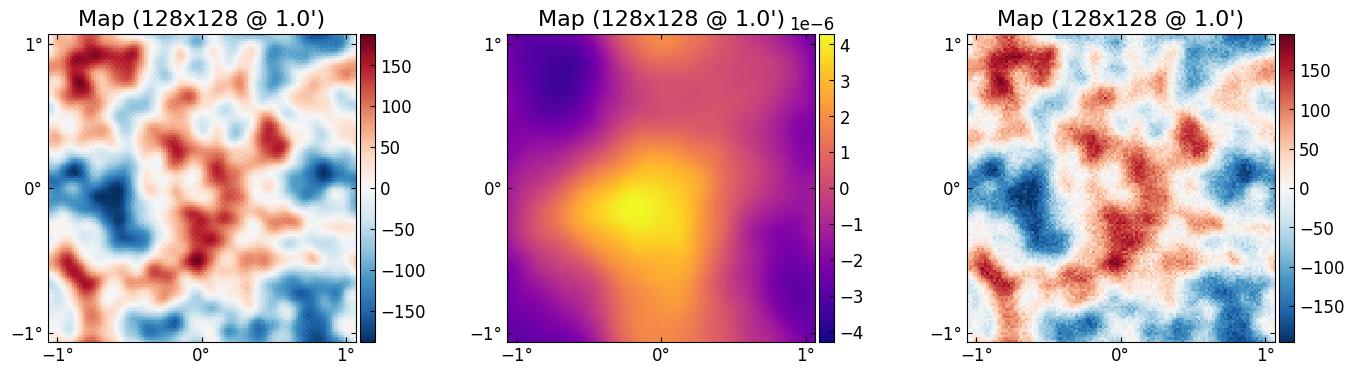

In [31]:
plot([sim.f sim.ϕ sim.d], cmap=["RdBu_r" "plasma" "RdBu_r"])

# Autodiff

For inference in high-dimensions, we _need_ gradients of the posterior probability. We use Zygote.jl for reverse-mode automatic differentation through the code.

In [32]:
using Zygote

In [33]:
gradient(x -> sin(x^2), 2)

(-2.6145744834544478,)

In [34]:
g = gradient((f, ϕ, Aϕ) -> logpdf(lensing_problem; f, ϕ, Aϕ, sim.d), sim.f, 0sim.ϕ, 1);

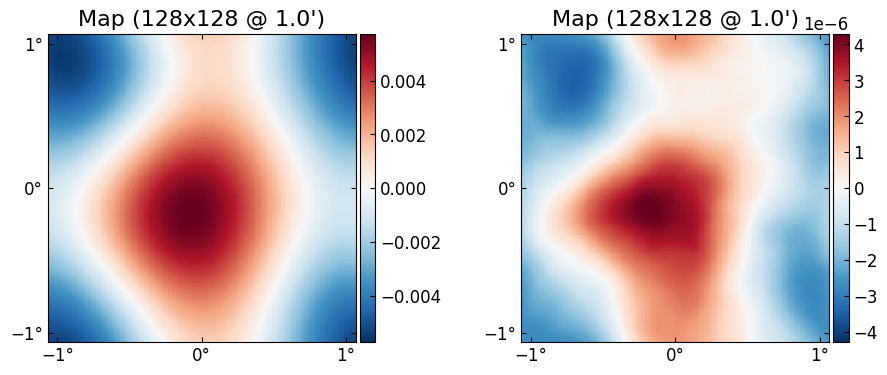

In [35]:
plot([Cϕ * g[2] sim.ϕ])

However, this was a pretty massive undertaking in understanding the internals of autodiff. For an example why:

In [36]:
struct MyIdentity <: AbstractMatrix{Real} end

In [37]:
Base.:*(::MyIdentity, v::AbstractVector) = v

In [38]:
# in the presentation I cheat, *this* is actually the first error 
# thats hit, but this doesn't demonstrate the point as nicely
import CMBLensing.Zygote.ChainRules: ProjectTo
ProjectTo(::MyIdentity) = identity

ProjectTo

In [39]:
mI = MyIdentity();

In [40]:
mI * [1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [41]:
gradient(v -> sum(mI * v), [1, 2, 3])

LoadError: MethodError: no method matching size(::MyIdentity)
[0mClosest candidates are:
[0m  size(::AbstractArray{T, N}, [91m::Any[39m) where {T, N} at ~/.julia/juliaup/julia-1.7.3+0.x64/share/julia/base/abstractarray.jl:42
[0m  size([91m::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}[39m) at ~/.julia/juliaup/julia-1.7.3+0.x64/share/julia/stdlib/v1.7/LinearAlgebra/src/qr.jl:567
[0m  size([91m::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}[39m, [91m::Integer[39m) at ~/.julia/juliaup/julia-1.7.3+0.x64/share/julia/stdlib/v1.7/LinearAlgebra/src/qr.jl:566
[0m  ...

Why the error? The relevent AD rule in ChainRules.jl (abridged) is:

```julia
function rrule(::typeof(*), A::AbstractVecOrMat, B::AbstractVecOrMat)
    function times_pullback(Ȳ)
        dA = Ȳ * B'
        dB = A' * Ȳ # <------- ERROR
        return NoTangent(), dA, dB
    end
    return A * B, times_pullback
end
```

$$
f(A, x) = A \, x \;\; \Rightarrow \;\;  \left(\frac{df}{dx}\right)^\dagger = A^\dagger
$$

so the AD rule needed me to also define the adjoint of `MyIdentity` (which I didn't otherwise "need").

The solution is to use [`ChainRules.@opt_out`](https://juliadiff.org/ChainRulesCore.jl/stable/rule_author/superpowers/opt_out.html#opt_out) (CMBLensing has its own custom version called `@auto_adjoint`). But it still feels like almost no AD works "out-of-the-box" for our custom types 😢. I wish the situation was better (although I dont have a solution)

# GPU



In [57]:
using CUDA

In [54]:
cu(f)

8320-element 128×128-pixel 1.0′-resolution LambertFourier{CuArray{ComplexF32, 2, CUDA.Mem.DeviceBuffer}}:
       -0.0f0 + 0.0f0im
  28018.639f0 - 200788.23f0im
              ⋮
 -114.14493f0 - 209.57422f0im
 -177.64098f0 + 52.85011f0im

In [60]:
Cf = cu(Cf)
Cϕ = cu(Cϕ)
Cn = cu(Cn);

In [61]:
sim = simulate(lensing_problem);

In [ ]:
g = gradient((f, ϕ, Aϕ) -> logpdf(lensing_problem; f, ϕ, Aϕ, sim.d), sim.f, 0sim.ϕ, 1);

# Inference with MUSE

In [48]:
using MuseInference

In [ ]:
(;ds) = load_sim(Nside=128, θpix=3, pol=:P, storage=CuArray);

In [ ]:
result = muse(ds, (Aϕ=2,));

In [55]:
# I also cheated during the presentation since it was hard to run this notebook 
# live on a cluster GPU, which would make this fast
result = MuseResult()
result.dist = Normal(1.05, 0.1);

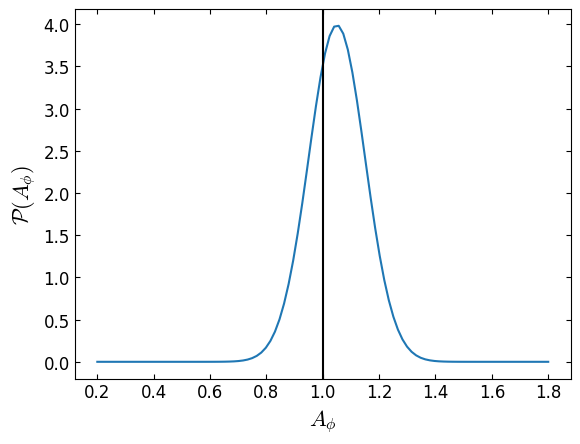

In [56]:
Aϕs = range(0.2, 1.8, length=100)
plot(Aϕs, pdf.(result.dist, Aϕs))
axvline(1, c="k")
xlabel(L"A_\phi")
ylabel(L"\mathcal{P}(A_\phi)");

# Conclusion

* CMBLensing.jl provides a unique solution to CMB lensing analysis which can provide ~10X better constraints that are currently possible, given the same data
* Julia made our custom array implementation and GPU a breeze.
* GPU offers a 10X speedup without which this analysis is unfeasible
* Autodiff is/was somewhat of a struggle. I am really looking forward to Diffractor.jl (although slighly worried about its percieved progress)
* Lots of useful packages in the ecosystem, although sometimes there are limitations to using them